In [2794]:
import math
import random
import numpy as np
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Dataset control unit

In [2795]:
DATASETS_DIR = "datasets"

TRAIN_PATH = pl.Path(f"{DATASETS_DIR}/train.csv");
TEST_PATH = pl.Path(f"{DATASETS_DIR}/test_features.csv");
SUBMISSION_PATH = pl.Path(f"{DATASETS_DIR}/sample_submission.csv");

## Analysis control unit

In [2796]:
USE_PAIRPLOTS = False
USE_BARPLOTS = True

In [2797]:
df = pd.read_csv(TRAIN_PATH)

### Analysing data from the available dataset

In [2798]:
df

,Sex,Length,Diameter,Height,weight_1,weight_2,weight_3,weight_4,target
0,M,0.725,0.550,0.200,1.5100,0.8735,0.4265,0.5085,9
1,F,0.415,0.340,0.130,0.3675,0.1460,0.0885,0.1200,10
2,M,0.705,0.555,0.215,2.1410,1.0465,0.3830,0.5280,11
3,I,0.375,0.290,0.095,0.2875,0.1230,0.0605,0.0800,6
4,F,0.680,0.500,0.185,1.7410,0.7665,0.3255,0.4685,12
...,...,...,...,...,...,...,...,...,...
3131,F,0.575,0.480,0.165,1.0780,0.5110,0.2095,0.3060,9
3132,M,0.585,0.455,0.125,1.0270,0.3910,0.2120,0.2500,17
3133,I,0.395,0.270,0.100,0.2985,0.1445,0.0610,0.0820,5
3134,M,0.415,0.305,0.100,0.3250,0.1560,0.0505,0.0910,6


In [2799]:
df.describe()

,Length,Diameter,Height,weight_1,weight_2,weight_3,weight_4,target
count,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000
mean,0.524141,0.407868,0.139115,0.829300,0.359130,0.180738,0.239251,9.948023
std,0.120807,0.099984,0.039111,0.492789,0.222860,0.110205,0.139756,3.290532
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.348750,0.115000,0.440500,0.184375,0.092875,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.801000,0.336000,0.171000,0.234500,9.000000
75%,0.615000,0.480000,0.165000,1.156500,0.503625,0.254000,0.330000,11.000000
max,0.815000,0.650000,0.515000,2.825500,1.488000,0.760000,0.897000,29.000000


In [2800]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3136 entries, 0 to 3135
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex       3136 non-null   object 
 1   Length    3136 non-null   float64
 2   Diameter  3136 non-null   float64
 3   Height    3136 non-null   float64
 4   weight_1  3136 non-null   float64
 5   weight_2  3136 non-null   float64
 6   weight_3  3136 non-null   float64
 7   weight_4  3136 non-null   float64
 8   target    3136 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 220.6+ KB


In [2801]:
if USE_PAIRPLOTS:
    sns.set()
    sns.pairplot(df[['Length', 'Height', 'Diameter', 'weight_1', 'weight_2', 'weight_3', 'weight_4']], diag_kind="kde")

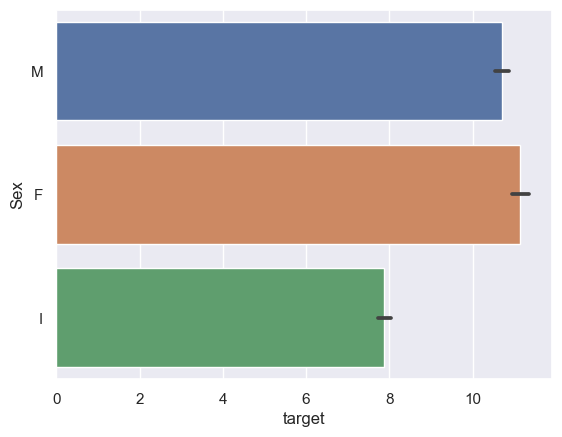

In [2802]:
if USE_BARPLOTS:
    sns.barplot(x=df['target'], y=df['Sex']);

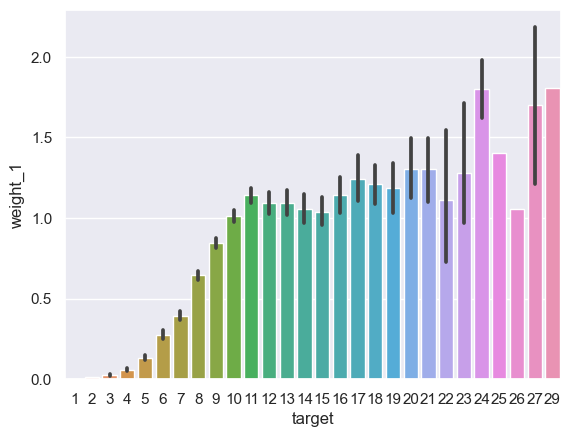

In [2803]:
if USE_BARPLOTS:
    sns.barplot(x=df['target'], y=df['weight_1']);

## Data control unit

In [2804]:
USE_FEATURE_EXTRACTION = True
USE_FEATURE_SCALING = True
USE_OUTLIER_DETECTION = True

### Data preprocessing

In [2805]:
df = pd.get_dummies(df, columns=["Sex"])

### Feature extraction

In [2806]:
if USE_FEATURE_EXTRACTION:
    df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
    df.drop(['Length', 'Diameter', 'Height'], axis=1, inplace=True)
    df['Weight'] = df['weight_1'] * df['weight_2'] * df['weight_3'] * df['weight_4']
    df.drop(['weight_1', 'weight_2', 'weight_3', 'weight_4'], axis=1, inplace=True)

### Data normalisation and filtration

In [2807]:
if USE_FEATURE_SCALING:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    if USE_FEATURE_EXTRACTION:
        scaling_columns = ["Volume", "Weight"]
    else:
        scaling_columns = ['Length', 'Diameter', 'Height', 'weight_1', 'weight_2', 'weight_3', 'weight_4']
    df[scaling_columns] = scaler.fit_transform(df[scaling_columns])

if USE_OUTLIER_DETECTION:
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

### Data visualisation after pipeline

In [2808]:
if USE_PAIRPLOTS:
    sns.set()
    if USE_FEATURE_EXTRACTION:
        sns.pairplot(df[['Weight', 'Volume']], diag_kind="kde")
    else:
        sns.pairplot(df[['Length', 'Diameter', 'Height', 'weight_1', 'weight_2', 'weight_3', 'weight_4']], diag_kind="kde")

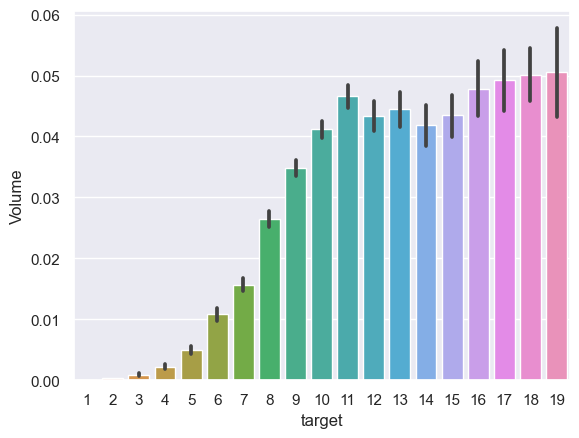

In [2809]:
if USE_BARPLOTS:
    if USE_FEATURE_EXTRACTION:
        sns.barplot(x=df['target'], y=df['Volume']);

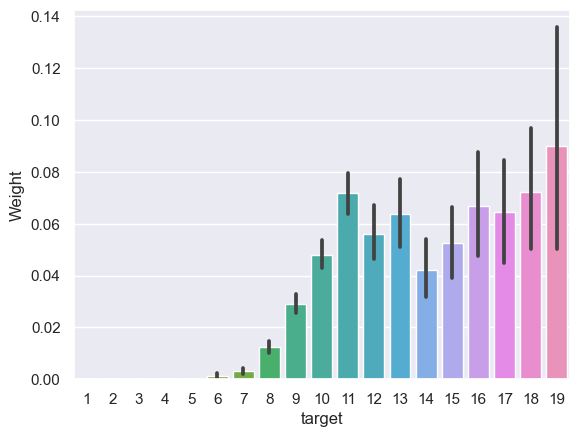

In [2810]:
if USE_BARPLOTS:
    if USE_FEATURE_EXTRACTION:
        sns.barplot(x=df['target'], y=df['Weight']);

### Building model

In [2811]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = [
#     MultiOutputClassifier(RandomForestClassifier(random_state=1), n_jobs=2),
#     OutputCodeClassifier(SVC(kernel='linear')), 
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=50),
    SVC(kernel='poly'), 
    SVC(kernel='linear'), 
    LogisticRegression(max_iter=200), 
    DecisionTreeClassifier()
]

verbose = False
experiments = 15
avg_accuracies = []
avg_rmses      = []

for model in models:
    print("-"*40)
    print(f"Analysing {type(model).__name__}")
    
    avg_rmse = 0
    avg_accuracy = 0
    
    for experiment in range(experiments):        
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=round(random.random() * 100))
        y_train, X_train = train_df['target'], train_df.drop('target', axis=1)
        y_test, X_test = test_df['target'], test_df.drop('target', axis=1)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        avg_rmse += rmse
        if verbose:
            print(f"RMSE in experiment {experiment + 1}: {rmse}")

        accuracy = model.score(X_test, y_test)
        avg_accuracy += accuracy
        if verbose:
            print(f"Accuracy in experiment {experiment + 1}: {accuracy * 100}%")

    avg_rmse /= experiments
    avg_rmses.append(avg_rmse)
    print(f"Average RMSE: {avg_rmse}")
    
    avg_accuracy /= experiments
    avg_accuracies.append(avg_accuracy)
    print(f"Average accuracy: {avg_accuracy * 100}%")
    
best_model = None 
best_rmse, best_accuracy = +math.inf, -math.inf

for model, avg_rmse, avg_accuracy in zip(models, avg_rmses, avg_accuracies):
    # if best_rmse > avg_rmse and best_accuracy < avg_accuracy:
    # if best_accuracy < avg_accuracy:
    if best_rmse > avg_rmse:
        best_rmse = avg_rmse
        best_accuracy = avg_accuracy
        best_model = model
        
print("-"*40)
print(f"Minimum RMSE: {best_rmse}%")
print(f"Maximum accuracy: {best_accuracy * 100}%")

----------------------------------------
Analysing GaussianNB
Average RMSE: 3.448788757277862
Average accuracy: 16.523652365236526%
----------------------------------------
Analysing KNeighborsClassifier
Average RMSE: 2.5763125261128166
Average accuracy: 25.863586358635864%
----------------------------------------
Analysing SVC
Average RMSE: 2.7490538803676543
Average accuracy: 19.40594059405941%
----------------------------------------
Analysing SVC
Average RMSE: 2.7773340820028802
Average accuracy: 19.262926292629263%
----------------------------------------
Analysing LogisticRegression
Average RMSE: 2.7161342516768476
Average accuracy: 21.14411441144114%
----------------------------------------
Analysing DecisionTreeClassifier
Average RMSE: 3.144027969801841
Average accuracy: 17.700770077007704%
----------------------------------------
Minimum RMSE: 2.5763125261128166%
Maximum accuracy: 25.863586358635864%


In [2812]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = df["target"].unique() # name of classes

Text(0.5, 427.9555555555555, 'Predicted label')

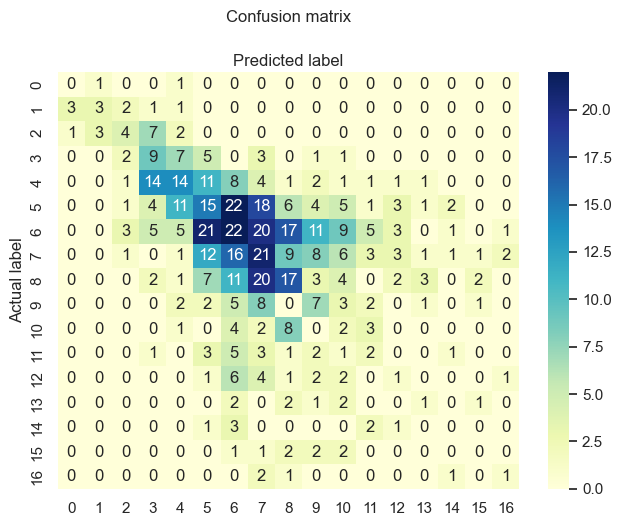

In [2813]:
# configure heatmap
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [2814]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.43      0.30      0.35        10
           5       0.29      0.24      0.26        17
           6       0.21      0.32      0.25        28
           7       0.30      0.24      0.27        59
           8       0.19      0.16      0.18        93
           9       0.21      0.18      0.19       123
          10       0.20      0.25      0.22        85
          11       0.26      0.24      0.25        72
          12       0.16      0.23      0.19        31
          13       0.05      0.10      0.07        20
          14       0.11      0.11      0.11        19
          15       0.07      0.06      0.06        18
          16       0.12      0.11      0.12         9
          17       0.00      0.00      0.00         7
          18       0.00      0.00      0.00         8
          19       0.20      0.20      0.20         5

    accuracy              

### Trying model with test data

In [2815]:
df = pd.read_csv(TEST_PATH)

In [2816]:
df = pd.get_dummies(df, columns=["Sex"])

In [2817]:
if USE_FEATURE_EXTRACTION:
    df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
    df.drop(['Length', 'Diameter', 'Height'], axis=1, inplace=True)
    df['Weight'] = df['weight_1'] * df['weight_2'] * df['weight_3'] * df['weight_4']
    df.drop(['weight_1', 'weight_2', 'weight_3', 'weight_4'], axis=1, inplace=True)

In [2818]:
if USE_FEATURE_SCALING:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    if USE_FEATURE_EXTRACTION:
        scaling_columns = ["Volume", "Weight"]
    else:
        scaling_columns = ['Length', 'Diameter', 'Height', 'weight_1', 'weight_2', 'weight_3', 'weight_4']
    df[scaling_columns] = scaler.fit_transform(df[scaling_columns])
    X_output = scaler.fit_transform(df)
else:
    X_output = df

In [2819]:
y_output = best_model.predict(X_output)

### Publishing test output to sample submission file

In [2820]:
df = pd.read_csv(SUBMISSION_PATH)
df['target'] = y_output

In [2821]:
df.to_csv(SUBMISSION_PATH)